## 实战Kaggle比赛：图像分类(CIFAR-10)
地址: [https://kaggle.com/c/cifar-10](https://kaggle.com/c/cifar-10)

In [1]:
import collections
import math
import os
import shutil
import pandas as pd

import torch
import torchvision
from torch import nn
from d2l import torch as d2l

为了便于入门，我们提供包含前1000个训练图像和5个随机测试图像的数据集的小规模样本。 要使用Kaggle竞赛的完整数据集，你需要将以下demo变量设置为False。

In [2]:
#@save
d2l.DATA_HUB['cifar10_tiny'] = (d2l.DATA_URL + 'kaggle_cifar10_tiny.zip',
                                '2068874e4b9a9f0fb07ebe0ad2b29754449ccacd')

# 如果你使用完整的Kaggle竞赛的数据集，设置demo为False
demo = False

if demo:
    data_dir = d2l.download_extract('cifar10_tiny')
else:
    data_dir = '../data/cifar-10/'

## 整理数据集

In [3]:
def read_csv_labels(fname):
    with open(fname, 'r') as f:
        lines = f.readlines()[1:]
    tokens = [l.rstrip().split(',') for l in lines]
    return dict(((name, label) for name, label in tokens))
labels = read_csv_labels(os.path.join(data_dir, 'trainLabels.csv'))

keys = list(labels.keys())
for i in range(10):
    print(keys[i], labels[keys[i]])


1 frog
2 truck
3 truck
4 deer
5 automobile
6 automobile
7 bird
8 horse
9 ship
10 cat


### 将验证集从原始的训练集中拆分出来

In [4]:
def copyfile(filename, target_dir):
    os.makedirs(target_dir, exist_ok=True)
    shutil.copy(filename, target_dir)

def reorg_train_valid(data_dir, labels, valid_ratio):
    """将验证集从原始的训练集中拆分出来"""
    # 训练数据集中样本最少的类别中的样本数
    n = collections.Counter(labels.values()).most_common()[-1][1]
    # 验证集中每个类别的样本数
    n_valid_per_label = max(1, math.floor(n * valid_ratio))
    label_count = {}
    for train_file in os.listdir(os.path.join(data_dir, 'train')):
        label = labels[train_file.split('.')[0]]
        fname = os.path.join(data_dir, 'train', train_file)
        copyfile(fname, os.path.join(data_dir, 'train_valid_test',
                                     'train_valid', label))
        if label not in label_count or label_count[label] < n_valid_per_label:
            copyfile(fname, os.path.join(data_dir, 'train_valid_test',
                                         'valid', label))
            label_count[label] = label_count.get(label, 0) + 1
        else:
            copyfile(fname, os.path.join(data_dir, 'train_valid_test',
                                         'train', label))
    return n_valid_per_label
            

### 在预测期间整理测试集，方便读取

In [5]:
#@save
def reorg_test(data_dir):
    """在预测期间整理测试集，以方便读取"""
    for test_file in os.listdir(os.path.join(data_dir, 'test')):
        copyfile(os.path.join(data_dir, 'test', test_file),
                 os.path.join(data_dir, 'train_valid_test', 'test',
                              'unknown'))



In [7]:
def reorg_cifar10_data(data_dir, valid_ratio):
    labels = read_csv_labels(os.path.join(data_dir, 'trainLabels.csv'))
    reorg_train_valid(data_dir, labels, valid_ratio)
    reorg_test(data_dir)
    
batch_size = 32 if demo else 128
# 验证集数据的比例
valid_ratio = 0.1
reorg_cifar10_data(data_dir, valid_ratio)

### 图像增广

In [8]:
# norms = [0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010]
norms = [0.485, 0.456, 0.406],[0.229, 0.224, 0.225]

transform_train = torchvision.transforms.Compose([
    # 图片本来是32 * 32，我们将它放大到40
    torchvision.transforms.Resize(40),
    # 随机剪裁，scala的配置表示最小保留原图的64%，最大保留100%
    # ratio不调整
    torchvision.transforms.RandomResizedCrop(32, scale=(0.64, 1.0),
                                             ratio=(1.0, 1.0)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(*norms)
])

transform_test = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(*norms)
])

### 读取由原始图像组成的数据集

In [9]:
train_ds, train_valid_ds = [
    torchvision.datasets.ImageFolder(
        os.path.join(data_dir, 'train_valid_test', folder),
        transform=transform_train) for folder in ['train', 'train_valid']]

valid_ds, test_ds = [torchvision.datasets.ImageFolder(
    os.path.join(data_dir, 'train_valid_test', folder),
    transform=transform_test) for folder in ['valid', 'test']]

### 定义DataLoader并使用增广

In [10]:
train_iter, train_valid_iter = [
    torch.utils.data.DataLoader(
        dataset, batch_size, shuffle=True, drop_last=True)
    for dataset in (train_ds, train_valid_ds)]

valid_iter = torch.utils.data.DataLoader(
    valid_ds, batch_size, shuffle=False, drop_last=True)

test_iter = torch.utils.data.DataLoader(test_ds, batch_size, shuffle=False,
                                        drop_last=False)

### 模型

In [11]:
import torchvision.models as models

def get_net():
    num_class = 10
    # 3表示输入是3通道
    net = d2l.resnet18(num_class, 3)
    return net

def get_resnet(num_class=10, n=18, pretrained=True):
    finetune_net = None
    if n == 101:
        finetune_net = models.resnet101(pretrained=pretrained)
    elif n == 32:
        finetune_net = models.resnet34(pretrained=pretrained)
    elif n == 50:
        finetune_net = models.resnet50(pretrained=pretrained)
    elif n == 152:
        finetune_net = models.resnet152(pretrained=pretrained)
    else:
        finetune_net = models.resnet18(pretrained=pretrained)
        
    finetune_net.fc = nn.Linear(finetune_net.fc.in_features, num_class)
    nn.init.xavier_uniform_(finetune_net.fc.weight)
    return finetune_net
    
loss = nn.CrossEntropyLoss(reduction='none')

### 训练函数

In [12]:
def train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period,
          lr_decay):
    """
    lr_period: 每个多少个epoch，降低学习率
    lr_decay: 直接跟lr相乘，用于降低学习率
    """
    trainer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9,
                              weight_decay=wd)
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_period, lr_decay)
    num_batches, timer = len(train_iter), d2l.Timer()
    legend = ['train loss', 'train acc']
    if valid_iter is not None:
        legend.append('valid acc')
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=legend)
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    for epoch in range(num_epochs):
        net.train()
        metric = d2l.Accumulator(3)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = d2l.train_batch_ch13(net, features, labels,
                                          loss, trainer, devices)
            metric.add(l, acc, labels.shape[0])
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[2], metric[1] / metric[2],
                              None))
        if valid_iter is not None:
            valid_acc = d2l.evaluate_accuracy_gpu(net, valid_iter)
            animator.add(epoch + 1, (None, None, valid_acc))
        # 更新lr scheduler
        scheduler.step()
    measures = (f'train loss {metric[0] / metric[2]:.3f}, '
                f'train acc {metric[1] / metric[2]:.3f}')
    if valid_iter is not None:
        measures += f', valid acc {valid_acc:.3f}'
    print(measures + f'\n{metric[2] * num_epochs / timer.sum():.1f}'
          f' examples/sec on {str(devices)}')

### 训练模型

train loss 0.133, train acc 0.956, valid acc 0.783
7054.7 examples/sec on [device(type='cuda', index=0)]


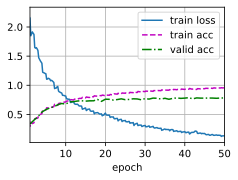

In [15]:
devices, num_epochs, lr, wd = d2l.try_all_gpus(), 50, 2e-4, 5e-4
# 每隔4个epoch之后，lr=0.9 * lr
lr_period, lr_decay, net = 4, 0.9, get_resnet(n=32)
train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period,
      lr_decay)

### 对测试集进行分类并提交结果

In [19]:
net, preds = get_resnet(n=32), []
# train(net, train_valid_iter, None, num_epochs, lr, wd, devices, lr_period, lr_decay)
net = net.to(devices[0])
for X, _ in test_iter:
    y_hat = net(X.to(devices[0]))
    preds.extend(y_hat.argmax(dim=1).type(torch.int32).cpu().numpy())
sorted_ids = list(range(1, len(test_ds) + 1))
sorted_ids.sort(key=lambda x: str(x))
df = pd.DataFrame({'id': sorted_ids, 'label': preds})
# label还原
df['label'] = df['label'].apply(lambda x: train_valid_ds.classes[x])
df.to_csv('../data/submissions/39_01_submission.csv', index=False)

/home/staneyffer/miniconda3/envs/dl-gpu/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/staneyffer/miniconda3/envs/dl-gpu/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
